# Поиск фото "Со смыслом"

Мы работаетем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Наш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

На основе лучшей модели можно будет собрать предварительную версию продукта, которую vы покажеv руководителю компании.

## Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
 - Имя файла изображения.
 - Идентификатор описания.
 - Доля людей, подтвердивших, что описание соответствует изображению.
 - Количество человек, подтвердивших, что описание соответствует изображению.
 - Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
 - Имя файла изображения.
 - Идентификатор описания.
 - 3, 4, 5 — оценки трёх экспертов. 

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
В папке test_images содержатся изображения для тестирования модели.

In [437]:
import numpy as np
import pandas as pd
import re
import nltk
import pickle
from os.path import exists, isfile, join


import tensorflow as tf
from spacy.lang.en.stop_words import STOP_WORDS
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
import swifter

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import spacy
nlp = spacy.load("en_core_web_sm")
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import notebook

np.random.seed(45)
from math import ceil


from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential

from tensorflow import keras
import seaborn as sns

import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import torch
torch.manual_seed(45)
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler, StandardScaler


tqdm.pandas()

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import ElasticNet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marys\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [460]:
path='C:/Users/marys/Pro4/to_upload'

## Загрузка данных

Скачаем  и откроем файлы с данными. Проверим данные и откорректируем их, если потребуется.

In [493]:
train_dataset = pd.read_csv('train_dataset.csv')

In [494]:
train_dataset.head(5)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [495]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [496]:
train_dataset = train_dataset.rename(columns={'image': 'file_name'})

In [497]:
print('Количество уникальных фото в тренировочном датасете:', len(train_dataset['file_name'].unique()))

Количество уникальных фото в тренировочном датасете: 1000


In [498]:
train_dataset.head()

file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [499]:
crowd = pd.read_csv('CrowdAnnotations.tsv',
                                sep='\t',
                                names=['file_name',
                                       'query_id',
                                       'final_score',
                                       'fits',
                                       'not_fits'])
display(crowd.head(5))
crowd.info()
crowd.describe()

file_name                     query_id  final_score  fits  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0     3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0     0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0     0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0     0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0     0   

   not_fits  
0         0  
1         3  
2         3  
3         3  
4         3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   final_score  47830 non-null  float64
 3   fits         47830 non-null  int64  
 4   not_fits     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


final_score          fits      not_fits
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

In [500]:
print('Количество уникальных сочетаний фото-текст, оцененных людьми:', crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст, оцененных людьми: 47830


In [501]:
expert = pd.read_csv('ExpertAnnotations.tsv',
                                 sep='\t',
                                 names=['file_name',
                                        'query_id',
                                        'first_expert',
                                        'second_expert',
                                        'third_expert'])
display(expert.head(5))
expert.info()
expert.describe()

file_name                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  
0              1             1  
1              1             2  
2              1             2  
3              2             2  
4              1             2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


first_expert  second_expert  third_expert
count   5822.000000    5822.000000   5822.000000
mean       1.436620       1.624356      1.881999
std        0.787084       0.856222      0.904087
min        1.000000       1.000000      1.000000
25%        1.000000       1.000000      1.000000
50%        1.000000       1.000000      2.000000
75%        2.000000       2.000000      2.000000
max        4.000000       4.000000      4.000000

In [502]:
print('Количество уникальных сочетаний фото-текст, оцененных экспертами:', expert.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст, оцененных экспертами: 5822


In [503]:
test_dataset = pd.read_csv('test_queries.csv',
                           sep='|',
                           index_col=0)
display(test_dataset.head(5))
test_dataset.info()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [505]:
test_dataset = test_dataset.rename(columns={'image': 'file_name'})

In [506]:
print('Количество уникальных фото в тестовом датасете:', len(test_dataset['file_name'].unique()))

Количество уникальных фото в тестовом датасете: 100


In [507]:
test_images = pd.read_csv('test_images.csv' )

In [509]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


Посмотрим на количество оценок в экспертном и краудсорсинговом наборах.

Проверим, все ли текстовые описания в тестовом наборе совпадают с картинками. В столбце query_id зашифрована информация о номере картинки к которой дано описание в столбце query_text.

In [510]:
test_dataset[test_dataset['query_id'].str[:-2] != test_dataset['file_name']].shape[0]

0

Проверим соответствие текстовых описаний друг другу в обучающем и тестовом датасетах.

In [511]:
print('Уникальных текстовых описаний в тренировочном датасете:', len(set(train_dataset['query_text'])))
print('Уникальных текстовых описаний в тестовом датасете:', len(set(test_dataset['query_text'])))
print('Уникальных текстовых описаний, которые есть в обоих датасетах:', len(set(train_dataset['query_text']) & set(test_dataset['query_text'])))

Уникальных текстовых описаний в тренировочном датасете: 977
Уникальных текстовых описаний в тестовом датасете: 500
Уникальных текстовых описаний, которые есть в обоих датасетах: 0


Проверим, не совпадают ли картинки в обучающем и тестовом наборах.

In [512]:
print('Уникальных картинок в тренировочном датасете:', len(set(train_dataset['file_name'])))
print('Уникальных картинок в тестовом датасете:', len(set(test_dataset['file_name'])))
print('Уникальных картинок, которые есть в обоих наборах:', len(set(train_dataset['file_name']) & set(test_dataset['file_name'])))

Уникальных картинок в тренировочном датасете: 1000
Уникальных картинок в тестовом датасете: 100
Уникальных картинок, которые есть в обоих наборах: 0


Посмотрим на изображения в датасетах.

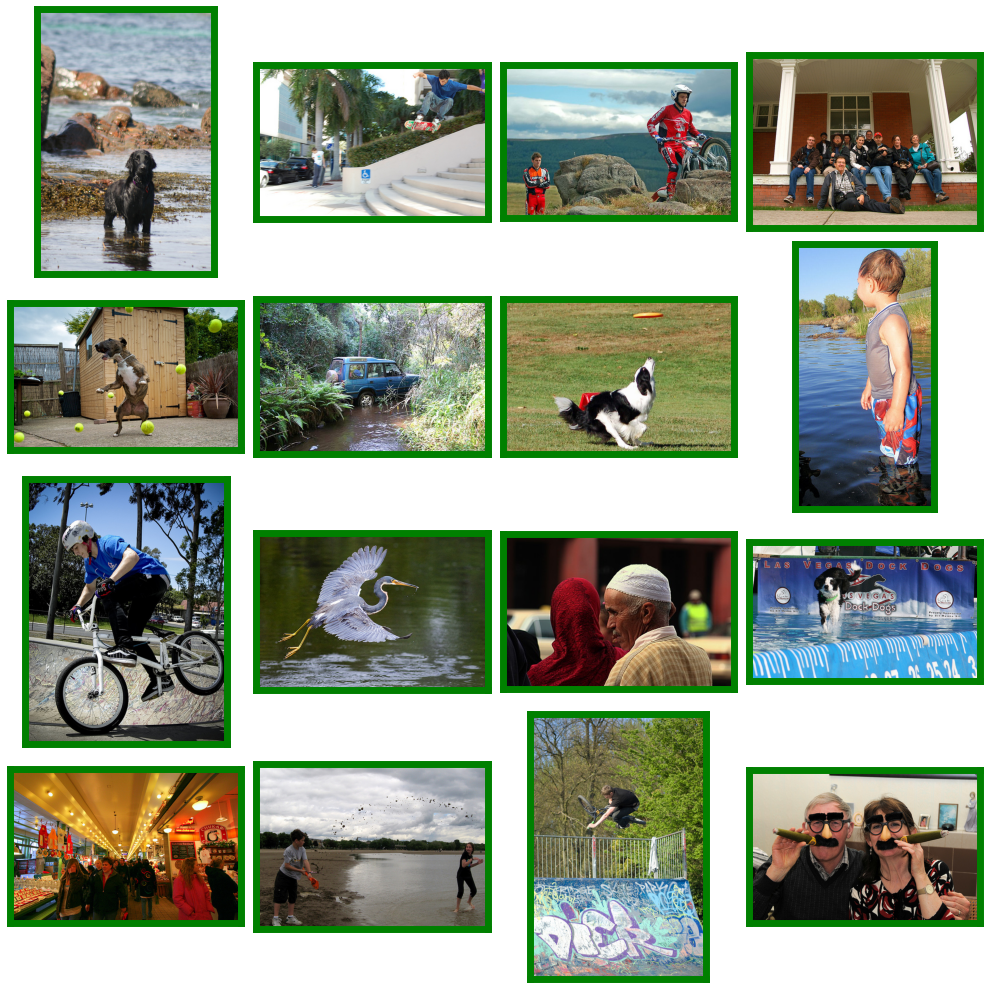

In [513]:
samples_train = list(train_dataset['file_name'].sample(8))
samples_test = list(test_dataset['file_name'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(path, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(path, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Агрегация оценок

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки агрегировать — превратить в одну. 

Если есть несколько одинаковых оценок - проголосуем большинством, если все оценки разные - будем усреднять оценку и приводить к диапазону [0,1].

In [514]:
def expert_aggregate(row) -> object:

    if row['first_expert'] == row['second_expert']  or row['first_expert'] == row['third_expert']:  
        row['expert_score'] = row['first_expert']
    elif  row['second_expert'] == row['third_expert']:
        row['expert_score'] = row['second_expert']    
        
    if row['first_expert'] != row['second_expert'] != row['third_expert']: #если оценки разные усредняем
        row['expert_score'] = (row['first_expert'] + row['second_expert'] + row['third_expert'] - 3) / 3 / 3
    

    return row

expert = expert.apply(expert_aggregate, axis=1)

In [515]:
expert.head()

file_name                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  expert_score  
0              1             1           1.0  
1              1             2           1.0  
2              1             2           1.0  
3              2             2           2.0  
4              1             2           1.0

In [516]:
mm_scaler = MinMaxScaler()

In [517]:
expert["expert_score"] = mm_scaler.fit_transform(expert[["expert_score"]])

In [518]:
expert.head()

file_name                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  expert_score  
0              1             1      0.181818  
1              1             2      0.181818  
2              1             2      0.181818  
3              2             2      0.454545  
4              1             2      0.181818

Не у всех пар картинка - описание есть оценки и людей, и экспертов. Там где есть оценка только людей либо экспертов - оставим её. Если есть обе оценки -  оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4. Далее мы объединим оценки.

In [519]:
scores = pd.merge(expert, crowd, how='outer', on=['file_name', 'query_id'])

def score_aggregate(row) -> object:

    if np.isnan(row['expert_score']):
        row['score'] = row['final_score']
    elif np.isnan(row['final_score']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.6 + row['final_score'] * 0.4
        
    return row

scores = scores.apply(score_aggregate, axis=1)

In [520]:
scores.head(10)

file_name                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           1.0   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           1.0   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2           1.0   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2           1.0   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2           1.0   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2           1.0   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2           1.0   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2           1.0   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2           2.0   

   second_expert  third_expert  expert_score  final_score  fits  not_fits  \
0            1.0           1.0      0.181818          0.0   0.0       3.0   
1            1.0           2.0      0.181818          0.0   0.0       3.0   
2            1.0           2.0      0.181818          NaN   NaN       NaN   
3            2.0           2.0      0.454545          NaN   NaN       NaN   
4            1.0           2.0      0.181818          NaN   NaN       NaN   
5            1.0           1.0      0.181818          NaN   NaN       NaN   
6            1.0           1.0      0.181818          NaN   NaN       NaN   
7            1.0           2.0      0.181818          0.0   0.0       3.0   
8            1.0           1.0      0.181818          NaN   NaN       NaN   
9            2.0           2.0      0.454545          NaN   NaN       NaN   

      score  
0  0.109091  
1  0.109091  
2  0.181818  
3  0.454545  
4  0.181818  
5  0.181818  
6  0.181818  
7  0.109091  
8  0.181818  
9  0.454545

Получили датасет с итоговой оценкой в диапазоне от 0 до 1.

In [521]:
scores.describe()

first_expert  second_expert  third_expert  expert_score   final_score  \
count   5822.000000    5822.000000   5822.000000   5822.000000  47830.000000   
mean       1.436620       1.624356      1.881999      0.341458      0.068786   
std        0.787084       0.856222      0.904087      0.236716      0.207532   
min        1.000000       1.000000      1.000000      0.000000      0.000000   
25%        1.000000       1.000000      1.000000      0.181818      0.000000   
50%        1.000000       1.000000      2.000000      0.181818      0.000000   
75%        2.000000       2.000000      2.000000      0.454545      0.000000   
max        4.000000       4.000000      4.000000      1.000000      1.000000   

               fits      not_fits         score  
count  47830.000000  47830.000000  51323.000000  
mean       0.208488      2.820155      0.088478  
std        0.628898      0.656676      0.211353  
min        0.000000      0.000000      0.000000  
25%        0.000000      3.000000      0.000000  
50%        0.000000      3.000000      0.000000  
75%        0.000000      3.000000      0.000000  
max        5.000000      6.000000      1.000000

In [522]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_name      51323 non-null  object 
 1   query_id       51323 non-null  object 
 2   first_expert   5822 non-null   float64
 3   second_expert  5822 non-null   float64
 4   third_expert   5822 non-null   float64
 5   expert_score   5822 non-null   float64
 6   final_score    47830 non-null  float64
 7   fits           47830 non-null  float64
 8   not_fits       47830 non-null  float64
 9   score          51323 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.9+ MB


In [523]:
train_dataset = pd.merge(train_dataset, scores[['file_name', 'query_id', 'score']], how='outer', on=['file_name', 'query_id'])

In [524]:
train_dataset.head()

file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.109091  
1  A young child is wearing blue goggles and sitt...  0.181818  
2  A young child is wearing blue goggles and sitt...  0.272727  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.181818

Соединили тренировочный датасет с датасетом оценок.

Заполним пропуски в описании после добавления оценок людей.

In [525]:
fill = train_dataset[train_dataset['query_text'].notna()]

In [526]:
def fill_text(row) -> object:

    if pd.isnull(row['query_text']):
        texts = fill[fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

train_dataset = train_dataset.apply(fill_text, axis=1)


In [527]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


После добавления текстов, оказалось что для части query_id нет описаний. Удалим их.

In [528]:
train_dataset.dropna(inplace=True)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


В тренировочном датасете 50214 строк.

### Проверка данных.

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

This image is unavailable in your country in compliance with local laws

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для избавления от нелегального контента мы воспользуемся текстовыми описаниями файлов.

Объявим список слов для поиска нелегального контента.

Очистим и лемматизируем текст, чтобы было легче искать запросы связанные с детьми. Отметим в обучающем наборе фото подлежащие блокировке.

In [529]:
child_stop = {
             'child', 
             'children',
             'baby', 
             'babies',
             'boy',
             'boys',
             'girl',
             'girls',
             'kid',
             'kids',
             'infant',
             'infants',
             'toddler',
             'toddlers'}

Применим Spacy для приведения текста к нужному виду.

In [239]:
def clean_text(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    lemmatized_output = ' '.join([w.lemma_ for w in clean])
    return lemmatized_output

На примере двух предложений, видим, что все получилось.

In [240]:
sentence1 = "A young child is wearing blue goggles and sitting in a float in a pool"
sentence2 = "A girl wearing a yellow shirt and sunglasses smiles"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)


print(df_my['text'].apply(clean_text))

                                                text
0  A young child is wearing blue goggles and sitt...
1  A girl wearing a yellow shirt and sunglasses s...
0    a young child be wear blue goggle and sit in a...
1        a girl wear a yellow shirt and sunglass smile
Name: text, dtype: object


Применим функцию лемматизации текста ко всему тренировочному датасету.

In [530]:
tqdm.pandas()
train_dataset['lemmatize'] = train_dataset['query_text'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 50214/50214 [03:18<00:00, 253.43it/s]


Создадим фукнцию, которая будем проверять наличие фильтрующих слов

In [531]:
def child_text(query_text):
    words = set(query_text.lower().split())
    return 0 != len(words & child_stop)

train_dataset['child'] = train_dataset['lemmatize'].\
    apply(child_text)

display(train_dataset.head())

file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  \
0  A young child is wearing blue goggles and sitt...  0.109091   
1  A young child is wearing blue goggles and sitt...  0.181818   
2  A young child is wearing blue goggles and sitt...  0.272727   
3  A young child is wearing blue goggles and sitt...  1.000000   
4  A young child is wearing blue goggles and sitt...  0.181818   

                                           lemmatize  child  
0  a young child be wear blue goggle and sit in a...   True  
1  a young child be wear blue goggle and sit in a...   True  
2  a young child be wear blue goggle and sit in a...   True  
3  a young child be wear blue goggle and sit in a...   True  
4  a young child be wear blue goggle and sit in a...   True

Удали строки, для которых был выставлен флаг 'child'.

In [532]:
train_dataset = train_dataset.loc[train_dataset['child'] == False]
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35911 entries, 22 to 51322
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_name   35911 non-null  object 
 1   query_id    35911 non-null  object 
 2   query_text  35911 non-null  object 
 3   score       35911 non-null  float64
 4   lemmatize   35911 non-null  object 
 5   child       35911 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 1.7+ MB


Видим, что в нашем тренировочном датасете осталось 35911 строк.

In [245]:
train_dataset.head()

file_name                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text     score  \
22  A man sleeps under a blanket on a city street .  0.181818   
23  A man sleeps under a blanket on a city street .  0.454545   
24  A man sleeps under a blanket on a city street .  0.272727   
25  A man sleeps under a blanket on a city street .  0.454545   
26  A man sleeps under a blanket on a city street .  0.181818   

                                       lemmatize  child  
22  a man sleep under a blanket on a city street  False  
23  a man sleep under a blanket on a city street  False  
24  a man sleep under a blanket on a city street  False  
25  a man sleep under a blanket on a city street  False  
26  a man sleep under a blanket on a city street  False

### Векторизация текстов

Для векторизации изображений воспользуемся трансформером Bert.

In [533]:
def make_embed(corpus):
    if isinstance(corpus, pd.Series):
        tokenized = corpus.swifter.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

        attention_mask = np.where(padded != 0, 1, 0)
        batch_size = 128
        embeddings = []
        for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

            with torch.no_grad():
                batch_embeddings = bert_model(batch,
                                              attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())
        return embeddings
    elif isinstance(corpus, str):
        tokenized = [tokenizer.encode(corpus, add_special_tokens=True)]
        attention_mask_tensor = torch.LongTensor(np.where(np.array(tokenized) != 0, 1, 0)).to(device)
        tokenized_tensor = torch.LongTensor(tokenized).to(device)
        embed = bert_model(tokenized_tensor, attention_mask=attention_mask_tensor)
        return embed[0][:,0,:].to('cpu').detach().numpy()
    else:
        print('Can\'t tokenize input.')
        return

In [534]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [535]:
bert_model = BertModel.from_pretrained('bert-base-uncased',
                                       output_hidden_states=True).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [536]:
vectorized_train_texts = pd.DataFrame(
    np.concatenate(
        make_embed(train_dataset['lemmatize']
                   .drop_duplicates()))
)
vectorized_train_texts['query_id'] = (train_dataset
                                      .drop_duplicates('query_text')
                                      .reset_index(drop=True)['query_id'])
print(vectorized_train_texts.shape)
vectorized_train_texts.head()

Pandas Apply:   0%|          | 0/688 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

(688, 769)


0         1         2         3         4         5         6  \
0  0.249386  0.052732 -0.371326  0.114516 -0.029452  0.096841  0.119418   
1  0.047277 -0.082113 -0.460516  0.128417  0.039319  0.076814 -0.109895   
2 -0.532864 -0.122207 -0.384824  0.119283 -0.071212 -0.143927  0.485139   
3 -0.134767 -0.314741 -0.463583 -0.031042  0.079968 -0.541141  0.288465   
4 -0.141898  0.175050  0.153127 -0.122655  0.134056 -0.356977  0.473795   

          7         8         9  ...       759       760       761       762  \
0  0.972561 -0.325949 -0.549660  ... -0.412041 -0.043481  0.014815  0.290990   
1  0.732929 -0.594590 -0.509253  ... -0.115204  0.027586  0.365203  0.370103   
2  1.288648 -0.822998 -0.440337  ... -0.635203  0.213393  0.578886  0.335962   
3  1.020582 -0.266126 -0.315731  ... -0.401648  0.404569  0.125417  0.210056   
4  0.709714 -0.306458 -0.704195  ... -0.405495 -0.097668 -0.012579 -0.000721   

        763       764       765       766       767  \
0  0.625550  0.106813 -0.377268  0.307420  0.030950   
1  0.526264  0.181218 -0.322933  0.206118 -0.090866   
2 -0.586097 -0.043065 -0.410720  0.571187  0.243433   
3  0.147263 -0.134317 -0.553442  0.467554 -0.133759   
4  0.416434  0.214992 -0.574205  0.282218 -0.398626   

                      query_id  
0  3181701312_70a379ab6e.jpg#2  
1  3207358897_bfa61fa3c6.jpg#2  
2  3286822339_5535af6b93.jpg#2  
3  3360930596_1e75164ce6.jpg#2  
4   434792818_56375e203f.jpg#2  

[5 rows x 769 columns]

Векторизация мзображений

Обратимся к свёрточным сетям. Возьмём архитектуру ResNet-50, посмотрим на слои и исключим полносвязные слои, которые отвечают за конечное предсказание. При этом загрузим модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Фунуция загрузки изображений.

In [537]:
def load_train(path) -> ImageDataGenerator:
   
    '''загрузчик данных для обучения'''
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=Path(path, 'train_images'),
        x_col='file_name',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=12345)
    
    return train_gen_flow

Посмторим, как работает загрузчик.

Found 35911 validated image filenames.


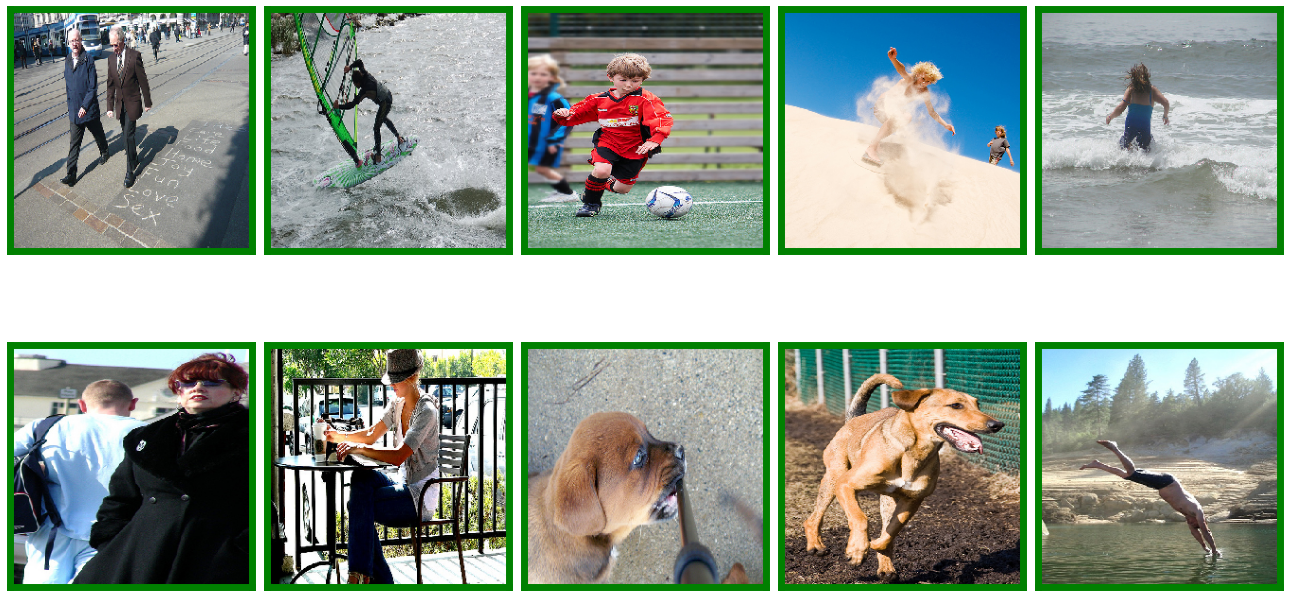

In [538]:
flow_train = load_train(path)
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Создадим модель.

In [539]:
def create_model(input_shape=(224, 224, 3)):
  
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

Получение векторов картинок.

In [541]:
def vectorize_pictures(model, train_data):
    
    '''превращаем данные в вектор'''
    
    predictions = model.predict(train_data)
    
    return predictions

In [542]:
%%time

img_vector = vectorize_pictures(create_model(), load_train(path))

Found 35911 validated image filenames.
2245/2245 [==============================] - 1534s 683ms/step
CPU times: total: 58min 3s
Wall time: 25min 38s


In [543]:
img_vector.shape

(35911, 2048)

In [544]:
vectorized_train_images = pd.DataFrame(np.vstack(img_vector))
vectorized_train_images['image'] = (train_dataset
                                    .drop_duplicates('file_name')
                                    .reset_index(drop=True)['file_name'])
vectorized_train_images.head()

0    1         2    3         4    5         6         7         8    9  \
0  0.0  0.0  0.003217  0.0  1.683627  0.0  0.000000  0.931830  0.016335  0.0   
1  0.0  0.0  0.002660  0.0  1.598310  0.0  0.002398  1.019715  0.027552  0.0   
2  0.0  0.0  0.000000  0.0  1.738543  0.0  0.000000  0.995019  0.042762  0.0   
3  0.0  0.0  0.000000  0.0  1.914788  0.0  0.000000  1.236993  0.019131  0.0   
4  0.0  0.0  0.000000  0.0  1.803665  0.0  0.000000  1.242667  0.024290  0.0   

   ...  2039  2040  2041      2042  2043  2044      2045  2046  2047  \
0  ...   0.0   0.0   0.0  0.114414   0.0   0.0  2.363359   0.0   0.0   
1  ...   0.0   0.0   0.0  0.012488   0.0   0.0  2.085568   0.0   0.0   
2  ...   0.0   0.0   0.0  0.123087   0.0   0.0  2.542661   0.0   0.0   
3  ...   0.0   0.0   0.0  0.153515   0.0   0.0  1.846085   0.0   0.0   
4  ...   0.0   0.0   0.0  0.096099   0.0   0.0  1.879352   0.0   0.0   

                       image  
0  1056338697_4f7d7ce270.jpg  
1  3187395715_f2940c2b72.jpg  
2   463978865_c87c6ca84c.jpg  
3   488590040_35a3e96c89.jpg  
4   534875358_6ea30d3091.jpg  

[5 rows x 2049 columns]

 Объединим векторы изображений и векторы текстов с целевой переменной (итоговой оценкой score).

In [545]:
train = (train_dataset
         .merge(vectorized_train_images,
                'left',
                left_on='file_name',
                right_on='image')
         .merge(vectorized_train_texts,
                'left',
                on='query_id')
         .drop(['query_id', 'image'],
               axis=1)
         .dropna()
         .reset_index(drop=True)
        )
print(train.shape)
train.head(20)

(35911, 2821)


file_name  \
0   1056338697_4f7d7ce270.jpg   
1   3187395715_f2940c2b72.jpg   
2    463978865_c87c6ca84c.jpg   
3    488590040_35a3e96c89.jpg   
4    534875358_6ea30d3091.jpg   
5   1056338697_4f7d7ce270.jpg   
6   3208074567_ac44aeb3f3.jpg   
7   3251976937_20625dc2b8.jpg   
8    370713359_7560808550.jpg   
9   1056338697_4f7d7ce270.jpg   
10  1962729184_6996e128e7.jpg   
11  2101457132_69c950bc45.jpg   
12  2225231022_1632d0a5aa.jpg   
13  3100251515_c68027cc22.jpg   
14   370614351_98b8a166b9.jpg   
15   391579205_c8373b5411.jpg   
16  1056338697_4f7d7ce270.jpg   
17  2311690895_0d6efe11c8.jpg   
18  2351479551_e8820a1ff3.jpg   
19  3217910740_d1d61c08ab.jpg   

                                           query_text     score  \
0     A man sleeps under a blanket on a city street .  0.181818   
1     A man sleeps under a blanket on a city street .  0.454545   
2     A man sleeps under a blanket on a city street .  0.272727   
3     A man sleeps under a blanket on a city street .  0.454545   
4     A man sleeps under a blanket on a city street .  0.181818   
5   A woman plays with long red ribbons in an empt...  0.454545   
6   A woman plays with long red ribbons in an empt...  0.181818   
7   A woman plays with long red ribbons in an empt...  0.181818   
8   A woman plays with long red ribbons in an empt...  0.109091   
9          Chinese market street in the winter time .  0.181818   
10         Chinese market street in the winter time .  0.000000   
11         Chinese market street in the winter time .  0.109091   
12         Chinese market street in the winter time .  0.181818   
13         Chinese market street in the winter time .  0.181818   
14         Chinese market street in the winter time .  0.181818   
15         Chinese market street in the winter time .  0.454545   
16  A soccer ball is above the head of a man weari...  0.181818   
17  A soccer ball is above the head of a man weari...  0.181818   
18  A soccer ball is above the head of a man weari...  0.109091   
19  A soccer ball is above the head of a man weari...  0.181818   

                                            lemmatize  child  0_x  1_x  \
0        a man sleep under a blanket on a city street  False  0.0  0.0   
1        a man sleep under a blanket on a city street  False  0.0  0.0   
2        a man sleep under a blanket on a city street  False  0.0  0.0   
3        a man sleep under a blanket on a city street  False  0.0  0.0   
4        a man sleep under a blanket on a city street  False  0.0  0.0   
5   a woman play with long red ribbon in an empty ...  False  0.0  0.0   
6   a woman play with long red ribbon in an empty ...  False  0.0  0.0   
7   a woman play with long red ribbon in an empty ...  False  0.0  0.0   
8   a woman play with long red ribbon in an empty ...  False  0.0  0.0   
9            chinese market street in the winter time  False  0.0  0.0   
10           chinese market street in the winter time  False  0.0  0.0   
11           chinese market street in the winter time  False  0.0  0.0   
12           chinese market street in the winter time  False  0.0  0.0   
13           chinese market street in the winter time  False  0.0  0.0   
14           chinese market street in the winter time  False  0.0  0.0   
15           chinese market street in the winter time  False  0.0  0.0   
16  a soccer ball be above the head of a man wear ...  False  0.0  0.0   
17  a soccer ball be above the head of a man wear ...  False  0.0  0.0   
18  a soccer ball be above the head of a man wear ...  False  0.0  0.0   
19  a soccer ball be above the head of a man wear ...  False  0.0  0.0   

         2_x       3_x       4_x  ...     758_y     759_y     760_y     761_y  \
0   0.003217  0.000000  1.683627  ... -0.125650 -0.412041 -0.043481  0.014815   
1   0.002660  0.000000  1.598310  ... -0.125650 -0.412041 -0.043481  0.014815   
2   0.000000  0.000000  1.738543  ... -0.125650 -0.412041 -0.043481  0.014815   
3   0.000000  0.000000  1.914788  ... -

In [546]:
train.shape

(35911, 2821)

Удалим колонки, котрые нам не понадобятся для обучения.

In [547]:
train=train.drop(columns=['query_text','lemmatize','child'])

In [548]:
train.shape

(35911, 2818)

In [549]:
train.head()

file_name     score  0_x  1_x       2_x  3_x       4_x  \
0  1056338697_4f7d7ce270.jpg  0.181818  0.0  0.0  0.003217  0.0  1.683627   
1  3187395715_f2940c2b72.jpg  0.454545  0.0  0.0  0.002660  0.0  1.598310   
2   463978865_c87c6ca84c.jpg  0.272727  0.0  0.0  0.000000  0.0  1.738543   
3   488590040_35a3e96c89.jpg  0.454545  0.0  0.0  0.000000  0.0  1.914788   
4   534875358_6ea30d3091.jpg  0.181818  0.0  0.0  0.000000  0.0  1.803665   

   5_x       6_x       7_x  ...    758_y     759_y     760_y     761_y  \
0  0.0  0.000000  0.931830  ... -0.12565 -0.412041 -0.043481  0.014815   
1  0.0  0.002398  1.019715  ... -0.12565 -0.412041 -0.043481  0.014815   
2  0.0  0.000000  0.995019  ... -0.12565 -0.412041 -0.043481  0.014815   
3  0.0  0.000000  1.236993  ... -0.12565 -0.412041 -0.043481  0.014815   
4  0.0  0.000000  1.242667  ... -0.12565 -0.412041 -0.043481  0.014815   

     762_y    763_y     764_y     765_y    766_y    767_y  
0  0.29099  0.62555  0.106813 -0.377268  0.30742  0.03095  
1  0.29099  0.62555  0.106813 -0.377268  0.30742  0.03095  
2  0.29099  0.62555  0.106813 -0.377268  0.30742  0.03095  
3  0.29099  0.62555  0.106813 -0.377268  0.30742  0.03095  
4  0.29099  0.62555  0.106813 -0.377268  0.30742  0.03095  

[5 rows x 2818 columns]

Получены вектора комбинаций изображение-запрос при помощи предобученной сети архитектуры ResNet50 для изображений и BERT для текстов. Размерность полученного вектора составляет 2048 + 768 = 2816. Входной слой полносвязной нейронной сети должно содержать 2816 нейронов.

### Обучение модели предсказания соответствия

Для обучения разделиv датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, можно воспользоваться классом GroupShuffleSplit из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

In [550]:
gss = GroupShuffleSplit(n_splits=1,
                        train_size=.7,
                        random_state=42)
train_indices, test_indices = next(gss.split(X=train.drop(columns=['score']),
                                             y=train['score'],
                                             groups=train['file_name']))
train_df, test_df = train.loc[train_indices], train.loc[test_indices]
train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)
print(train_df.shape, test_df.shape)

(24975, 2818) (10936, 2818)


#### Линейная регрессия

Поскольку решается задача регрессии (предсказания оценки соответствия запрса и картинки), необходимо выбрать соответвующую метрику. Выберем среднюю абсолютную ошибку (MAE), так как она легко интерпретируется (значение покажет нам в абсолютных единицах, насколько ошибается модель). Используем модель с регуляризацией, это не даст модели сильно переобучиться.

In [551]:
lin_reg = ElasticNet(alpha=0.001, random_state=45)

In [552]:
lin_reg.fit(train_df.drop(columns=['score', 'file_name']),
            train_df['score'])
lr_preds = lin_reg.predict(test_df.drop(columns=['score', 'file_name']))

print(mean_absolute_error(test_df['score'], lr_preds))

0.14357861731342375


#### Полносвязная нейронная сеть

Создадим трёхслоёную нейронную сеть.

In [554]:
NN = Sequential()
NN.add(Dense(2816, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.MeanSquaredError()])

NN.build()

NN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2816)              7932672   
                                                                 
 batch_normalization_8 (Bat  (None, 2816)              11264     
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 256)               721152    
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                                 
Total params: 8666369 (33.06 MB)
Trainable params: 86

Преобразуем обучающую и тестовую выборки в тензоры для использования в нейросети, обучим нейросеть.
Для оценки качества будем использовать MSE. Она измеряет среднее значение квадратов разностей между предсказанными и фактическими значениями. 

In [555]:
X_train_tensor = torch.FloatTensor(train_df.drop(columns=['score', 'file_name']).values).to(device)
X_train_tensor = tf.cast(X_train_tensor, tf.float32)
y_train_tensor = torch.FloatTensor(train_df['score'].values).to(device)
y_train_tensor = tf.cast(y_train_tensor, tf.float32)
X_val_tensor = torch.FloatTensor(test_df.drop(columns=['score', 'file_name']).values).to(device)
y_val_tensor = torch.FloatTensor(test_df['score'].values).to(device)
X_val_tensor = tf.cast(X_val_tensor, tf.float32)
y_val_tensor = tf.cast(y_val_tensor, tf.float32)

In [556]:
NN.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_val_tensor, y_val_tensor),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10
781/781 - 65s - loss: 0.1647 - mean_squared_error: 0.1647 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - 65s/epoch - 83ms/step
Epoch 2/10
781/781 - 64s - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0873 - val_mean_squared_error: 0.0873 - 64s/epoch - 82ms/step
Epoch 3/10
781/781 - 63s - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.0588 - val_mean_squared_error: 0.0588 - 63s/epoch - 80ms/step
Epoch 4/10
781/781 - 63s - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - 63s/epoch - 80ms/step
Epoch 5/10
781/781 - 63s - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0948 - val_mean_squared_error: 0.0948 - 63s/epoch - 80ms/step
Epoch 6/10
781/781 - 64s - loss: 0.0595 - mean_squared_error: 0.0595 - val_loss: 0.0577 - val_mean_squared_error: 0.0577 - 64s/epoch - 82ms/step
Epoch 7/10
781/781 - 63s - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - 63s/epo

Сделаем предсказания на валидационной выборке.

In [557]:
predicted_valid = NN.predict(X_val_tensor)
mse = mean_squared_error(y_val_tensor, predicted_valid)

342/342 [==============================] - 2s 5ms/step


In [558]:
mse

0.077411495

В дальнейшем остановимся на использовании нейросети.

### Тестирование модели.

In [559]:
child_block = [
             'child', 
             'children',
             'baby', 
             'babies',
             'boy',
             'boys',
             'girl',
             'girls',
             'kid',
             'kids',
             'infant',
             'infants',
             'toddler',
             'toddlers']

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картинок с максимальной предсказанной оценкой схожести.

In [572]:
def get_picture(text) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''
    
    if len(set(text.split()) & set(child_stop)) > 0:
        print ('This image is unavailable in your country in compliance with local laws')
    else:
        text_embed = make_embed(text) 
        X = np.concatenate(( 
            img_vector_test,
            np.resize(text_embed, (img_vector_test.shape[0],768))),
            axis=1)
        predictions = NN.predict(X) 
        df = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) 
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) 
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) 
        
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        
        fig = plt.figure(figsize=(15,5)) 
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(path, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if text in list(test_dataset['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(path, 'test_images', test_dataset.iloc[test_dataset[test_dataset['query_text'] == text].index[0]]['file_name']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        plt.show()

    return None

Создадим загрузчик тестовых изображений. проверим, как он работает.

In [563]:
def load_test(path) -> ImageDataGenerator:
    
    '''загрузчик данных для тестирования'''
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=test_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=12345)
    
    return train_gen_flow

Found 100 validated image filenames.


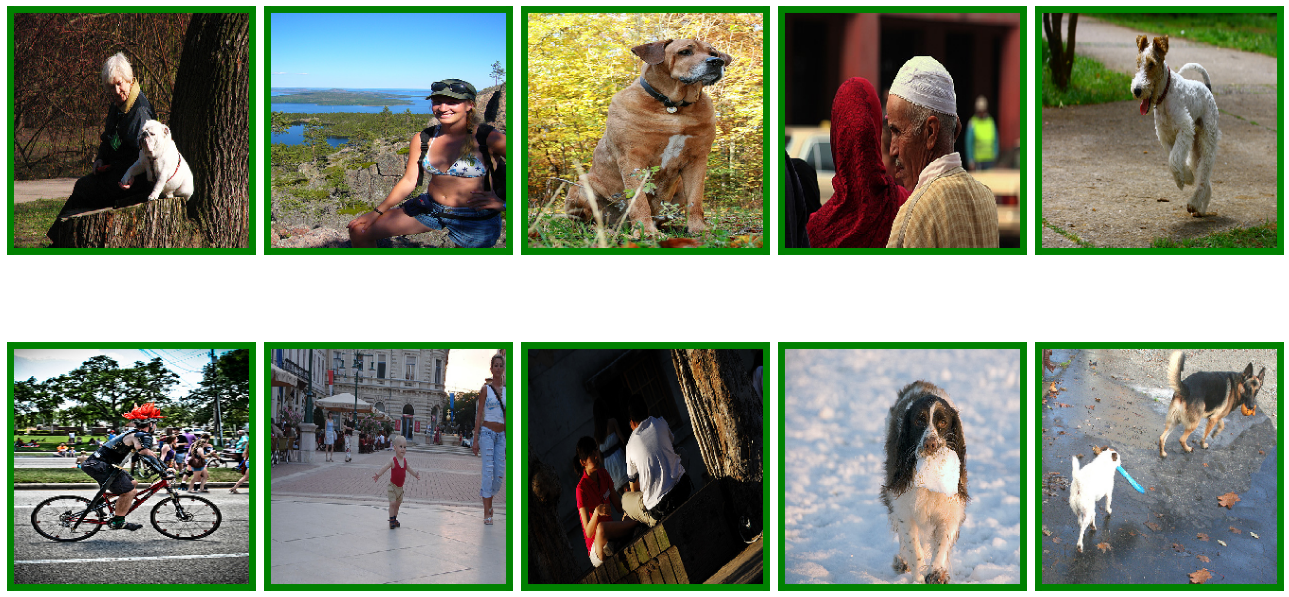

In [564]:
flow_train = load_test(path)
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Получим вектора тестовых картинок.

In [565]:
%%time

img_vector_test = vectorize_pictures(create_model(), load_test(path))
img_vector_test.shape

Found 100 validated image filenames.
7/7 [==============================] - 5s 574ms/step
CPU times: total: 9.72 s
Wall time: 6.89 s


(100, 2048)

Выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты.

In [566]:
samp = test_dataset.sample(10)
text_test = list(samples['query_text'])
text_test

['The dog is running .',
 'A man with glasses wearing all black sits on grass surrounded by other people .',
 'Two dogs stand in the brown grass .',
 'A group of girls who are gothically dressed standing together',
 'An Afican American woman standing behind two small African American children .',
 'A woman and two children pose for a picture under some rocks .',
 'The young boy flings mud at the barefoot girl in the pond .',
 'A boy jumps up in a field in the woods .',
 'Three children stand on or near a fence .',
 'Woman with glasses working at a sewing machine .']

4/4 [==============================] - 0s 8ms/step

-------------------- The dog is running . --------------------



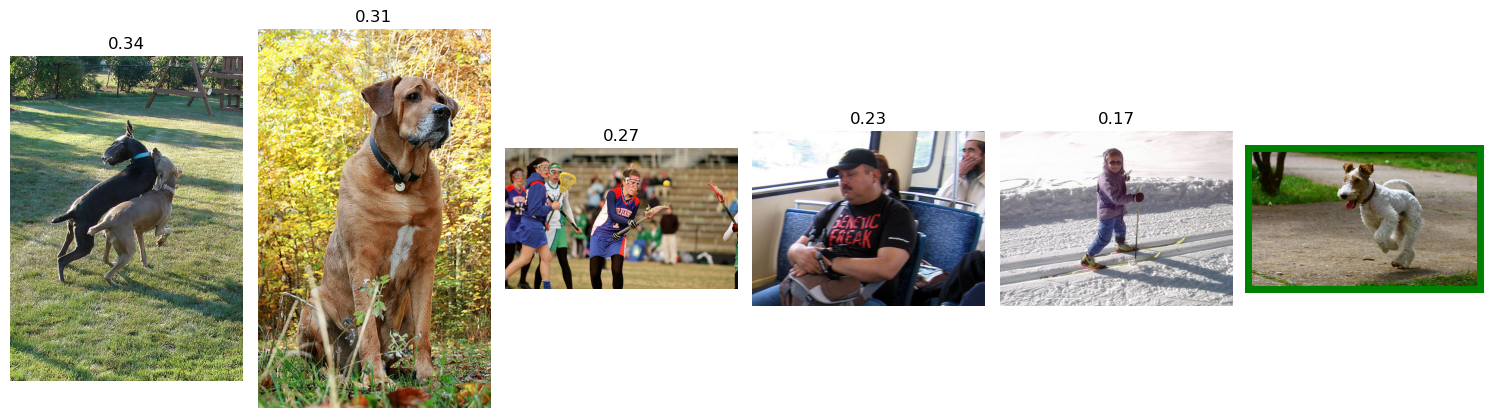

4/4 [==============================] - 0s 7ms/step

-------------------- A man with glasses wearing all black sits on grass surrounded by other people . --------------------



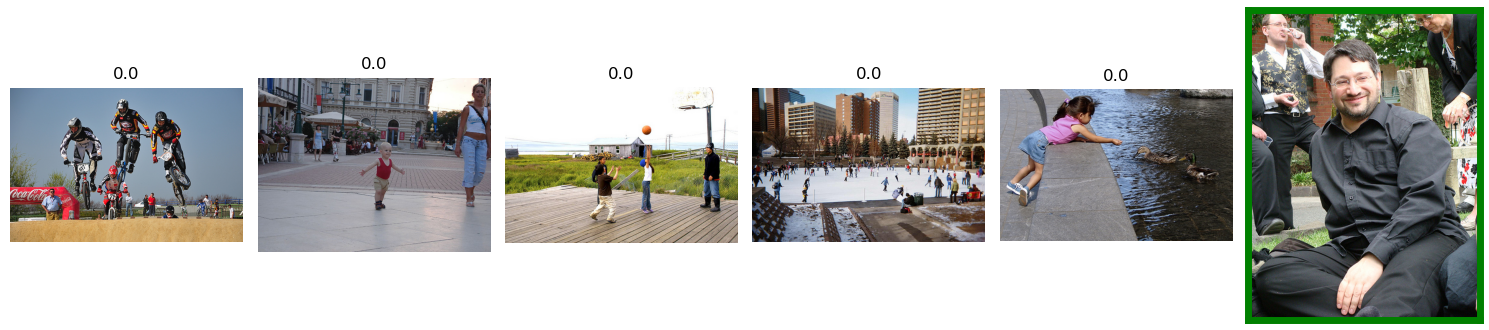

4/4 [==============================] - 0s 8ms/step

-------------------- Two dogs stand in the brown grass . --------------------



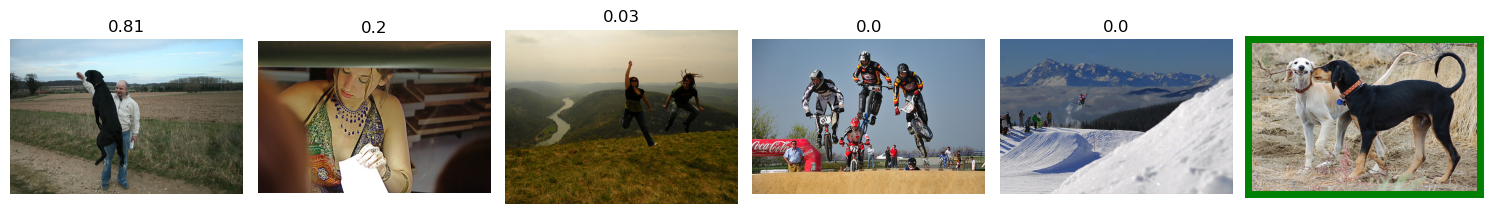

This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
4/4 [==============================] - 0s 5ms/step

-------------------- Woman with glasses working at a sewing machine . --------------------



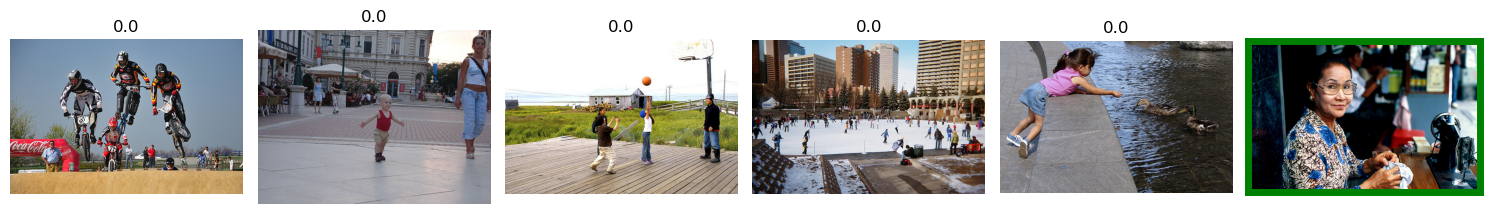

In [573]:
for text in text_test:
    get_picture(text)

Видим, что нужная картинка не попала в запрос. Иногда попадают картинки, схожие по смыслу.

## Вывод
Нам было поручено разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии мы обучили модели, которык получат векторное представление изображения, векторное представление текста, а на выходе выдадут число от 0 до 1 — покажут, насколько текст и картинка подходят друг другу.

В ходе работы для векторизации изображений были использованы сеть ResNet50, а для текстовых эмбеддингов BERT.

После объединения признаков и выделения целей (экспертные оценки схожести описания и картинок), мы исследовали две модели для оценки схожести:

LinearSVR
трёхслойную нейронную сеть

Лучше всего себя показала нейронная сеть, она и была протестирована.

Попадания в топ5 выдачи  верной картинки не обнаружено, иногда попадают картинки, связанные тематически.

В качестве возможных путей для решения можно предложить использовать более полный набор изображений для обучения, доработку архитектуры нейронной сети.